# Music-Learning

## Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in [`1`](https://arxiv.org/abs/1612.01840).

In [1]:
#Imports
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
from sklearn.metrics import precision_score, accuracy_score, auc, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
import tensorflow as ft
from tensorflow import keras
from keras.models import Sequential
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import make_pipeline

import ast
import os
import cmath

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from plot_utils import basic_plot

2022-09-20 22:19:29.910086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 22:19:30.008537: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-20 22:19:30.012895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 22:19:30.012914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Data preprocessing
There is the need to do some preliminar operations on the data extracted by the .mp3 files:

1. First, there are some columns (the 'Fourier' related) that have complex numbers as values.
These values can't be treated by the ML models so are discared

2. The labels have to be encoded to be processed in the right way

In [18]:
from dataset_utils import drop_complex_cols, get_top_genres
dataset_path = "csv_file.csv"
music_df = pd.read_csv(dataset_path, encoding='latin-1') 
X = music_df.drop(columns=["filename", "artist", "title", "album"])  # drop song metadata
y = X["genre"]  # extract labels
labels = y.unique()
X = X.drop(columns="genre")

X = X.drop(columns=drop_complex_cols(X))



path = "dataset/fma_metadata/genres.csv"
top_genres = get_top_genres(path)
print(top_genres)

        
# First method: infer the genre by the parent
inferred_genres = []
for genre in y:
    genre_to_add = ""
    for top in top_genres:
        if str(top).lower() in str(genre).lower():
             genre_to_add = str(top).lower()
             break
    if genre_to_add == "":
        genre_to_add = str(genre).lower()
    inferred_genres.append(genre_to_add)
    genre_to_add = ""

inferred_genres = pd.Series(np.array(inferred_genres))
f = open("tracce.csv", "w")
for genre in inferred_genres.unique():
    f.write(str(genre)+"\n")
f.close()

# This dictionary is a report of the number of tracks per each genre
tracks_dict = {}
for track in inferred_genres:
    if track not in tracks_dict:
        tracks_dict[track] = 1
    else:
        tracks_dict[track] += 1

print(tracks_dict, len(tracks_dict))

key_set = list(tracks_dict.keys())
print(type(key_set))
keys_to_pop = []

for key in key_set:
    for key2 in key_set:
        if key in key2:
            total_song = tracks_dict[key] + tracks_dict[key2]
            keys_to_pop.append(key2)
            #tracks_dict.pop(key2)
            tracks_dict[key] = total_song
print(keys_to_pop)
print(tracks_dict)

['International', 'Blues', 'Jazz', 'Classical', 'Old-Time / Historic', 'Country', 'Pop', 'Rock', 'Easy Listening', 'Soul-RnB', 'Electronic', 'Folk', 'Spoken', 'Hip-Hop', 'Experimental', 'Instrumental']
{'hip-hop': 233, 'pop': 65, 'psychedelic': 3, 'folk': 259, 'revival': 1, 'lo-fi': 14, 'jazz': 71, 'metal': 24, 'nan': 93, 'electronic': 264, 'other': 25, 'avant-garde': 43, 'rock': 573, 'punk': 80, 'electroacoustic': 2, 'reggae - dub': 6, 'loud': 5, 'latin': 11, 'disco': 42, 'international': 66, 'noise': 32, 'drone': 2, 'other - misc': 1, 'blues': 17, 'field recording': 5, 'unknown': 7, 'plunderphonic': 2, 'audio collage': 50, 'singer-songwriter': 5, 'electro-punk': 23, 'alternative & punk': 1, 'ambient': 14, 'no wave': 5, 'experimental': 22, 'progressive': 1, 'spoken': 7, 'bluegrass': 26, 'garage': 41, 'indie': 5, 'post-punk': 16, 'balkan': 8, 'hardcore': 20, 'latin america': 21, 'ethnic': 6, 'french': 5, 'americana': 25, 'middle east': 3, 'classical': 64, 'old-time / historic': 37, 'br

In [ ]:
# Helper function (temporary)
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [5]:
# Open file, extract feature set and label set
path = "dataset/fma_metadata/"
tracks_file = "tracks.csv"
features_file = "features.csv"
ds_features = load(path+features_file)
ds_tracks = load(path+tracks_file)

medium = ds_tracks['set', 'subset'] <= 'medium'
X = ds_features.loc[medium, 'mfcc']
y = ds_tracks.loc[medium, ('track', 'genre_top')]

## SVM

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                            test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                            test_size=0.10)


#pca = PCA(n_components=20)
#X_train = pca.fit_transform(X_train)
#X_validate = pca.fit_transform(X_validate)
#X_test = pca.fit_transform(X_test)
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

svm_clf = skl.svm.SVC(C=5, kernel='rbf').fit(X_train, y_train)
print(cross_val_score(svm_clf, X_validate, y_validate))  # print validation score

svm_predictions = svm_clf.predict(X_test)
print(svm_clf.score(X_test,y_test))  # print accuracy

# Gather metrics

svm_precision = precision_score(y_test, svm_predictions, average=None)#, labels=labels)
svm_recall = recall_score(y_test, svm_predictions, average=None)#, labels=labels)
svm_f1 = f1_score(y_test, svm_predictions, average=None)#, labels=labels)
svm_cm = confusion_matrix(y_test, svm_predictions)

print("------------------------- SVM completed -------------------------")

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[0.56       0.56       0.54       0.54444444 0.57555556]
0.6196
------------------------- SVM completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LR
The second classifier used is Logistic Regression

In [15]:
# Some previous feature selection
#X_fs = X
#lr_clf = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga').fit(X_fs, y)
#model = SelectFromModel(lr_clf, prefit=True)
#X_new = model.transform(X_fs)
#print(X_new.shape)

# Split in train, test and validation, and fit the classifier to the new feature set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42, 
                                                    test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                    test_size=0.10)
lr_clf = LogisticRegression(C=1, penalty="l1", dual=False, solver='saga').fit(X_new, y)
lr_predictions = lr_clf.predict(X_test)
print(lr_clf.score(X_test, y_test))

lr_precision = precision_score(y_test, lr_predictions, average=None)#, labels=labels)
lr_recall = recall_score(y_test, lr_predictions, average=None)#, labels=labels)
lr_f1 = f1_score(y_test, lr_predictions, average=None)#, labels=labels)
lr_cm = confusion_matrix(y_test, lr_predictions)

print("------------------------- LR completed -------------------------")

0.616
------------------------- LR completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## kNN
As third classifier we have k-Nearest-Neighbours.

In [8]:
# the actual classification
n_neighbors_best = 10
knn = KNeighborsClassifier(n_neighbors_best)
knn.fit(X_train, y_train)

knn_predictions = knn.predict(X_test)
print(knn.score(X_test, y_test))


knn_precision = precision_score(y_test, knn_predictions, average=None)#, labels=labels)
knn_recall = recall_score(y_test, knn_predictions, average=None)#, labels=labels)
knn_f1 = f1_score(y_test, knn_predictions, average=None)#, labels=labels)
knn_cm = confusion_matrix(y_test, knn_predictions)


print("------------------------- kNN completed -------------------------")

0.5984
------------------------- kNN completed -------------------------


/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MLP
The last classifier considered was Multi Layer Perceptron

/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/lib/

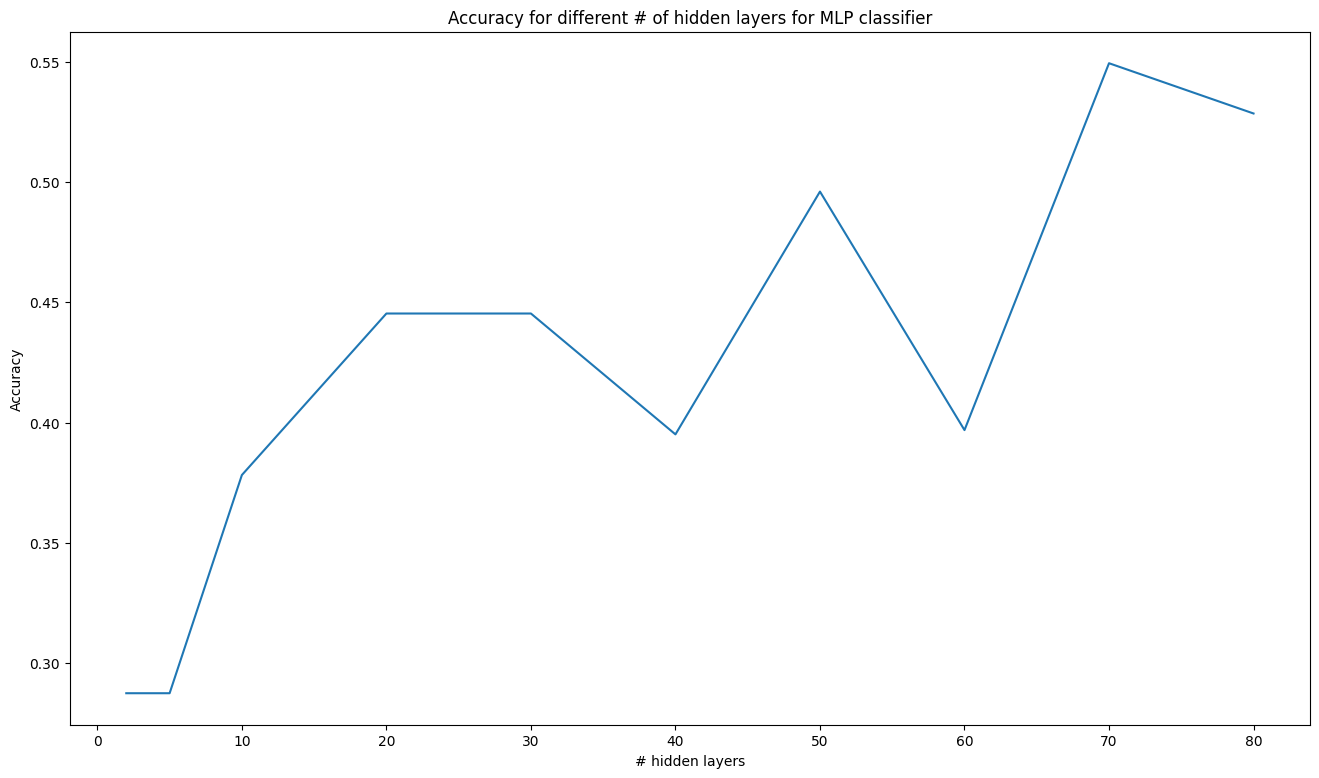

In [9]:
# Tuning for the value of the hidden layers
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=42, 
                                                            test_size=0.10)
hlayers = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80]
mlp_scores = []
for h_layer in hlayers:
    mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(h_layer,), 
                            random_state=1)
    mlp_clf.fit(X_train, y_train)
    mlp_scores.append(np.asarray(cross_val_score(mlp_clf, X_validate, y_validate, cv=2)).mean())
    
basic_plot((16,9), hlayers, mlp_scores, "# hidden layers", "Accuracy", 
           "Accuracy for different # of hidden layers for MLP classifier")

In [12]:
n_hidden_opt = 70
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n_hidden_opt,), 
                            random_state=1)
mlp_clf.fit(X_train, y_train)

mlp_predictions = mlp_clf.predict(X_test)
print(mlp_clf.score(X_test, y_test))

mlp_precision = precision_score(y_test, mlp_predictions, average=None)#, labels=labels)
mlp_recall = recall_score(y_test, mlp_predictions, average=None)#, labels=labels)
mlp_f1 = f1_score(y_test, mlp_predictions, average=None)#, labels=labels)
mlp_cm = confusion_matrix(y_test, mlp_predictions)

0.592


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classifiers metrics and comparison
Last, we evaluate performance metrics for the different classifiers and compare the
results obtained.

We compute 4 different metrics for each classifier:

| Metric | Expression|
|:-------- | :-------------------------------------------------: |
| Accuracy | $\tfrac{TN + TP}{TP+FP+TN+FN}$ |
| Precision | $\tfrac{TP}{TP + FP}$ |
| Recall | $\tfrac{TP}{TP + FN}$ |
| F1-score | $2 \cdot \tfrac{Precision \cdot Recal}{Precision + Recal}$ |

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
N.B: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balance.

In [ ]:
# TODO: confusion matrix displays wrong label order

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print("---------------------------------------------------------------------------------------\n")
print("SVM results:")

#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, svm_preds)))

plt.figure(figsize=(25,10))
plt.bar(labels, svm_precision)
plt.title('Precision metric values for SVM')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, svm_recall)
plt.title('Recall metric values for SVM')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, svm_f1)
plt.title('F1 metric values for SVM')
plt.show()

# Confusion matrix for SVM
#svm_cm = confusion_matrix(y_test, svm_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 


print("---------------------------------------------------------------------------------------\n")

print("kNN results: ")
#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, knn_predictions)))
plt.figure(figsize=(25,10))
plt.bar(labels, knn_precision)
plt.title('Precision metric values for kNN')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, knn_recall)
plt.title('Recall metric values kNN')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, knn_f1)
plt.title('F1 metric values kNN')
plt.show()

# Confusion matrix for kNN
#knn_cm = confusion_matrix(y_test, knn_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = knn_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 

print("---------------------------------------------------------------------------------------\n")

print("Linear Regression results: ")
#print("    Accuracy: ", "{:.2f}".format(accuracy_score(y_test, lr_preds)))
plt.figure(figsize=(25,10))
plt.bar(labels, lr_precision)
plt.title('Precision metric values for LR')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, lr_recall)
plt.title('Recall metric values for LR')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, lr_f1)
plt.title('F1 metric values for LR')
plt.show()

# Confusion matrix for LR
#lr_cm = confusion_matrix(y_test, lr_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 

print("---------------------------------------------------------------------------------------\n")
print("Multi Layer Perceptron results: ")
plt.figure(figsize=(25,10))
plt.bar(labels, mlp_precision)
plt.title('Precision metric values for MLP')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, mlp_recall)
plt.title('Recall metric values for MLP')
plt.show()

plt.figure(figsize=(25,10))
plt.bar(labels, mlp_f1)
plt.title('F1 metric values for MLP')
plt.show()

# Confusion matrix for SVM
#mlp_cm = confusion_matrix(y_test, mlp_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = mlp_cm, display_labels = labels) 
plt.figure(figsize=(30,20))
cm_display.plot()
plt.show() 

print("---------------------------------------------------------------------------------------\n")

## Conclusions
Conclusioni tipo:
- "miglior" classificatore
- limiti e difficoltà incontrare
- etc...

## Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)